# Epistemic loss as a function of training epoch

In [2]:
from scripts import train, models, analysis, io
import torch
import matplotlib.pyplot as plt

First initialize the model.

In [37]:
noise_level = 'high'
if noise_level == 'high':
    noise = 10
model_name = 'SDER_noise_'+noise_level
#model_name = 
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)
DEVICE = get_best_device()
model, _ = train.model_setup_DER(DER_type, DEVICE)

In [46]:
def load_model_checkpoint(model, model_name, epoch, device, path='../models'):
    """
    Load PyTorch model checkpoint from a .pt file.

    :param path: Location to load the model from
    :param DER_type: Type of your model
    :param epoch: Epoch to load
    :param device: Device to load the model onto ('cuda' or 'cpu')
    :param model: PyTorch model to load the checkpoint into
    :return: Loaded model
    """
    file_name = f"{path}/{model_name}_{epoch}.pt"
    
    checkpoint = torch.load(file_name, map_location=device)
    
    # Handle the case where extra information is present in the state_dict
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    # Extract additional information
    loaded_epoch = checkpoint.get('epoch', None)
    med_u_ep_validation = checkpoint.get('med_u_ep_validation', None)
    med_u_al_validation = checkpoint.get('med_u_al_validation', None)

    return model, loaded_epoch, med_u_ep_validation, med_u_al_validation

In [47]:
loadmodel_high, epoch_high, ep_high, al_high = load_model_checkpoint(model, model_name, 1, DEVICE)

In [48]:
print(loadmodel_high, epoch_high, ep_high, al_high)

Sequential(
  (0): Model(
    (model): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (1): SDERLayer()
) 10 1.8602488


In [71]:
ep_high = []
al_high = []
ep_medium = []
al_medium = []
ep_low = []
al_low = []

n_epochs = 500
for e in range(n_epochs):
    _, _, epistemic_h, aleatoric_h = load_model_checkpoint(model,
                                                           'SDER_noise_high',
                                                           e, DEVICE)
    ep_high.append(epistemic_h)
    al_high.append(aleatoric_h)
    _, _, epistemic_m, aleatoric_m = load_model_checkpoint(model,
                                                           'SDER_noise_medium',
                                                           e, DEVICE)
    ep_medium.append(epistemic_m)
    al_medium.append(aleatoric_m)
    _, _, epistemic_l, aleatoric_l = load_model_checkpoint(model,
                                                           'SDER_noise_low',
                                                           e, DEVICE)
    ep_low.append(epistemic_l)
    al_low.append(aleatoric_l)
    

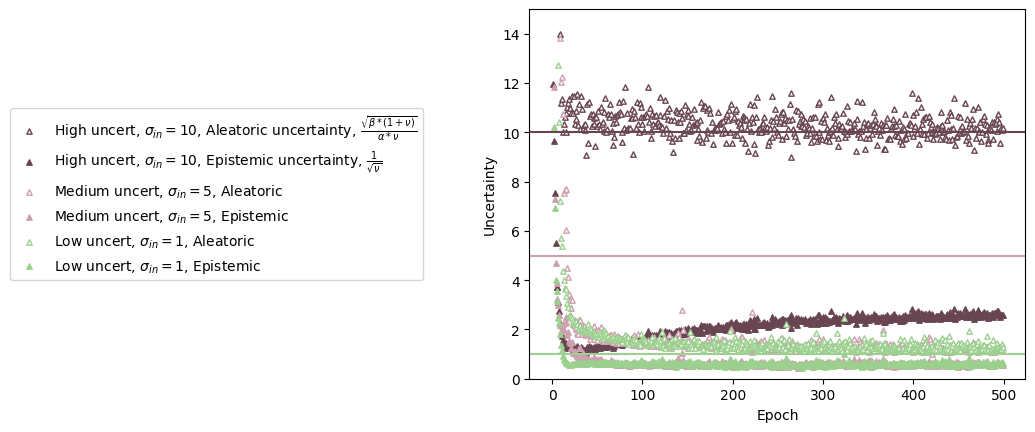

In [79]:
# overplot both
ptsize = 15
plt.clf()
plt.scatter(range(n_epochs), al_high,
            edgecolor = '#684551',
            color = 'white',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plt.scatter(range(n_epochs), ep_high,
            color = '#684551',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plt.axhline(y = 10,
            color = '#684551')

plt.scatter(range(n_epochs), al_medium,
            edgecolor = '#CEA0AE',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Aleatoric')
plt.scatter(range(n_epochs), ep_medium,
            color = '#CEA0AE',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Epistemic')
plt.axhline(y = 5,
            color = '#CEA0AE')
plt.scatter(range(n_epochs), al_low,
            edgecolor = '#9CD08F',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Aleatoric')
plt.scatter(range(n_epochs), ep_low,
            color = '#9CD08F',
            marker = '^',
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Epistemic')
plt.axhline(y = 1,
            color = '#9CD08F')
# total = sqrt(ep^2 + al^2)
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.ylim([0,15])

plt.show()
